In [1]:
# Install necessary libraries if you haven't already
!pip install datasets tensorflow

# Import necessary libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from datasets import load_dataset
!pip install seacrowd


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 5.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.3/52.3 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  P

In [2]:


# Load the Liputan6 dataset
dataset = load_dataset('SEACrowd/liputan6', trust_remote_code=True)

# Access 'train', 'validation', and 'test' splits
train_data = dataset['train']
valid_data = dataset['validation']
test_data = dataset['test']

# Limiting dataset sizes for training, validation, and testing
train_data = train_data.select(range(1000))  # 10,000 training examples
valid_data = valid_data.select(range(150))  # 150 validation examples
test_data = test_data.select(range(100))  # 100 test examples


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/3.23k [00:00<?, ?B/s]

liputan6.py:   0%|          | 0.00/7.52k [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

In [3]:
# Extract texts and summaries
train_texts = train_data['document']
train_summaries = train_data['summary']

valid_texts = valid_data['document']
valid_summaries = valid_data['summary']

test_texts = test_data['document']
test_summaries = test_data['summary']

# Initialize Tokenizer for texts and summaries
tokenizer_text = Tokenizer()
tokenizer_text.fit_on_texts(train_texts)

tokenizer_summary = Tokenizer()
tokenizer_summary.fit_on_texts(train_summaries)

# Convert texts and summaries into sequences of integers
train_text_sequences = tokenizer_text.texts_to_sequences(train_texts)
valid_text_sequences = tokenizer_text.texts_to_sequences(valid_texts)
test_text_sequences = tokenizer_text.texts_to_sequences(test_texts)

train_summary_sequences = tokenizer_summary.texts_to_sequences(train_summaries)
valid_summary_sequences = tokenizer_summary.texts_to_sequences(valid_summaries)
test_summary_sequences = tokenizer_summary.texts_to_sequences(test_summaries)

# Pad sequences to ensure uniform length
max_text_length = 400
max_summary_length = 50

train_text_sequences = pad_sequences(train_text_sequences, maxlen=max_text_length, padding='post')
valid_text_sequences = pad_sequences(valid_text_sequences, maxlen=max_text_length, padding='post')
test_text_sequences = pad_sequences(test_text_sequences, maxlen=max_text_length, padding='post')

train_summary_sequences = pad_sequences(train_summary_sequences, maxlen=max_summary_length, padding='post')
valid_summary_sequences = pad_sequences(valid_summary_sequences, maxlen=max_summary_length, padding='post')
test_summary_sequences = pad_sequences(test_summary_sequences, maxlen=max_summary_length, padding='post')


In [14]:
# Step 1: Define the model
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer_text.word_index) + 1, output_dim=100, input_length=max_text_length))
model.add(SimpleRNN(128))
model.add(RepeatVector(max_summary_length))
model.add(SimpleRNN(128, return_sequences=True))
model.add(TimeDistributed(Dense(len(tokenizer_summary.word_index) + 1, activation='softmax')))

# Step 2: Set up callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

# Step 3: Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Step 4: Train the model
history = model.fit(train_text_sequences, train_summary_sequences, batch_size=64, epochs=10,
          validation_data=(valid_text_sequences, valid_summary_sequences),
          callbacks=[early_stopping, model_checkpoint])  # Add callbacks here

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.2967 - loss: 8.4015 - val_accuracy: 0.6215 - val_loss: 6.2939
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.4485 - loss: 6.4491 - val_accuracy: 0.6215 - val_loss: 4.3756
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.4544 - loss: 5.1940 - val_accuracy: 0.6215 - val_loss: 3.5292
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.4510 - loss: 4.9906 - val_accuracy: 0.6215 - val_loss: 3.5004
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.4505 - loss: 4.9626 - val_accuracy: 0.6215 - val_loss: 3.5480
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.4564 - loss: 4.9050 - val_accuracy: 0.6215 - val_loss: 3.5345
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.4568 - loss: 4.8938 - val_accuracy: 0.6215 - val_loss: 3.5313
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.4542 - loss: 4.8882 - val_accuracy: 0.6215 - val_loss:

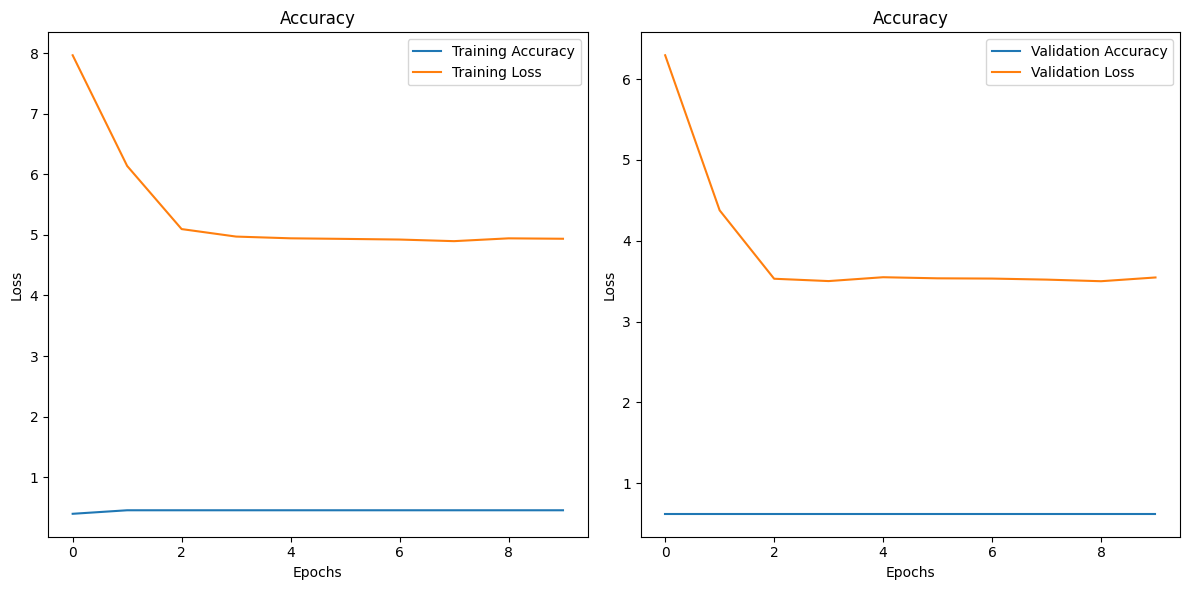

In [16]:
import matplotlib.pyplot as plt
# Step 6: Plot accuracy and loss
plt.figure(figsize=(12, 6))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [17]:
# Step 1: Generate predictions for the test data
generated_summaries = model.predict(test_text_sequences[:2])  # Use only the first two test examples

# Step 2: Convert the predicted summaries (3D array) to a 2D array of indices (batch_size, max_summary_length)
generated_summaries = np.argmax(generated_summaries, axis=-1)

# Step 3: Convert the predicted indices back to words
reverse_summary_word_index = {v: k for k, v in tokenizer_summary.word_index.items()}
generated_summary_texts = []

# Iterate through each generated summary to map indices to words and join them into a sentence
for i, summary in enumerate(generated_summaries):
    # Filter out padding token (0) and map each index to its corresponding word
    summary_text = ' '.join([reverse_summary_word_index.get(idx, '') for idx in summary if idx != 0])
    generated_summary_texts.append(summary_text)

    # Print input text and its corresponding generated summary for the first two test examples
    print(f"Input Text {i+1}:")
    print(test_texts[i])  # Original input text
    print(f"Generated Summary {i+1}:")
    print(generated_summary_texts[i])  # Generated summary
    print("\n" + "-"*50 + "\n")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
Input Text 1:
Liputan6 . com , Bangka : Kapal patroli Angkatan Laut Republik Indonesia , Belinyu , baru-baru ini , menangkap tiga kapal nelayan berbendera Thailand , yakni KM Binatama , KM Sumber Jaya II , dan KM Mataram di Perairan Belitung Utara . Ketiga kapal itu ditangkap karena melanggar zona ekonomi ekslusif Indonesia . Saat ini , kapal-kapal itu diamankan di Pos Lanal Pelabuhan Pangkalan Balam , Bangka-Belitung . Menurut Komandan Pangkalan TNI AL Bangka Letnan Kolonel Laut Fredy Egam , selain menangkap tiga kapal , ALRI juga memeriksa 43 anak buah kapal . Mereka disergap saat sedang mengangkat jaring pukat harimau di Perairan Belitung Utara . Dari jumlah itu , hanya enam orang yang dijadikan tersangka , yakni tiga nahkoda dan tiga kepala kamar mesin kapal . Sedangkan ABK yang lain akan dideportasi ke negara asalnya . Meski berhasil menahan enam tersangka , TNI AL gagal mengamankan ikan tangkapan nelayan Thailand tersebut . Sebab , sebelum pa